<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 図書館
- [図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t000021d2000000003/resource/7108f0a3-0257-424a-9722-e84999a01392)

In [1]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 8.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
score_name = '図書館スコア'
output_master_file = 'library_master.csv'
output_score_file = 'library_score.csv'

In [5]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import math
import io
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [7]:
def get_distance_from_facility(longitude, latitude, df_facility):
    return df_facility.apply(lambda x: get_distance(x['緯度'], x['経度'], longitude, latitude), axis=1)

In [8]:
extract_columns = ['施設分類', '名称', '市区町村名', '所在地', '緯度', '経度']

In [9]:
tokyo_library_url = 'https://www.opendata.metro.tokyo.lg.jp/kyouiku/R3/skshubetu_4.csv'
df_tokyo_library = get_data_csv_url(tokyo_library_url, encoding='shift-jis')
print(df_tokyo_library.shape)

df_tokyo_library = df_tokyo_library[df_tokyo_library['施設名'].notna()]
df_tokyo_library = df_tokyo_library[(~df_tokyo_library['施設名'].str.contains('閉館'))&(df_tokyo_library['区市町村名'].str.endswith('区'))]
df_tokyo_library['施設名'] = df_tokyo_library['施設名'].str.replace('＊\?', '', regex=True).str.replace('\?\?', '', regex=True)
df_tokyo_library = df_tokyo_library.rename(columns={'施設区分':'施設分類', '施設名':'名称', '区市町村名':'市区町村名'})[extract_columns].reset_index(drop=True)
print(df_tokyo_library.shape)

(418, 9)
(233, 6)


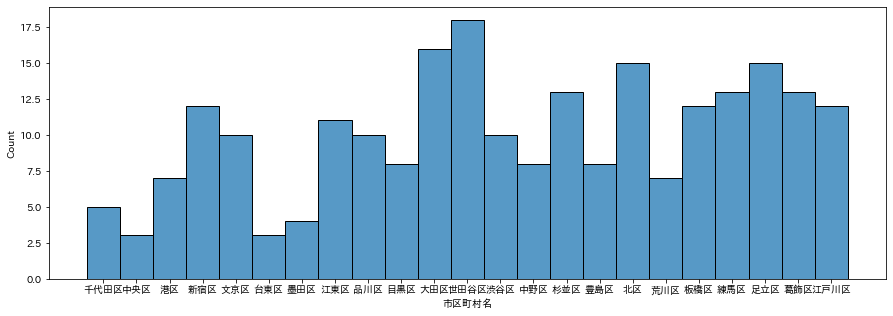

In [10]:
plt.figure(figsize=(15, 5))
sns.histplot(x='市区町村名', data=df_tokyo_library)
plt.show()

## 図書館マスタ

In [11]:
df_library_master = df_tokyo_library
df_library_master.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,図書館,昌平まちかど図書館,千代田区,千代田区外神田3-4-7,35.701223,139.769873
1,図書館,神田まちかど図書館,千代田区,千代田区神田司町2-16,35.693357,139.768304
2,図書館,四番町図書館,千代田区,千代田区四番町1,35.690453,139.741601
3,図書館,千代田図書館,千代田区,千代田区九段南1-2-1千代田区役所9･10階,35.693997,139.753585
4,図書館,日比谷図書文化館,千代田区,千代田区日比谷公園1-4,35.671872,139.754602


In [12]:
df_library_master.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

## 人口マスタ

In [13]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


In [14]:
%%time
# 一番近い施設の距離
df_pop_master['図書館(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_library_master, '図書館', 'min')
# 近い3件の距離の平均
df_pop_master['図書館(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_library_master, '図書館', 'mean', 3)
# 2km以内の施設の数
df_pop_master['図書館(数)'] = get_value_of_nearest_facility(df_pop_master, df_library_master, '図書館', 'count', 2)

CPU times: user 1min 10s, sys: 311 ms, total: 1min 10s
Wall time: 1min 18s


In [15]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 9)


,地域ID,市区町村名,町名,町丁目,緯度,経度,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,1.286453,1.301848,5
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,1.242295,1.349516,5
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,1.000856,1.274480,4
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.687988,1.136131,5
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.772108,1.182786,6


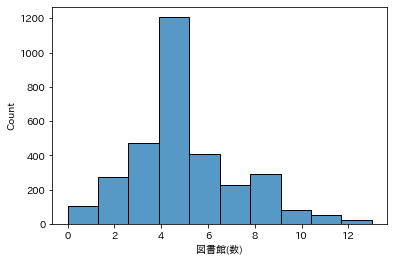

In [16]:
sns.histplot(df_pop_master['図書館(数)'], bins=10)
plt.show()

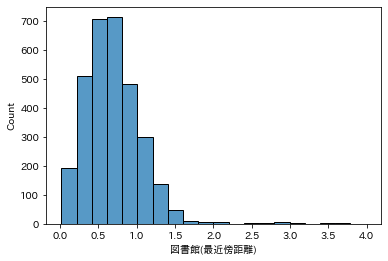

In [17]:
sns.histplot(df_pop_master['図書館(最近傍距離)'], bins=20)
plt.show()

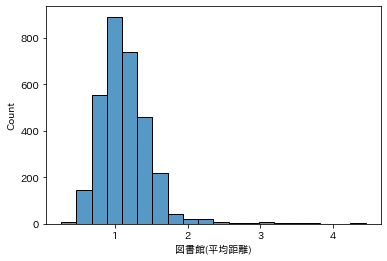

In [18]:
sns.histplot(df_pop_master['図書館(平均距離)'], bins=20)
plt.show()

In [19]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

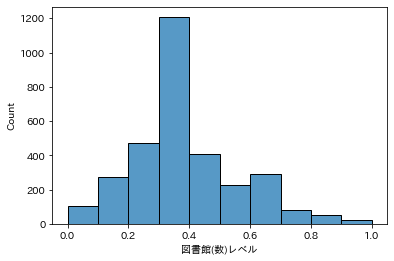

In [20]:
df_pop_master['図書館(数)レベル'] = normalize_score(df_pop_master['図書館(数)'], outlier=False)
sns.histplot(df_pop_master['図書館(数)レベル'], bins=10)
plt.show()

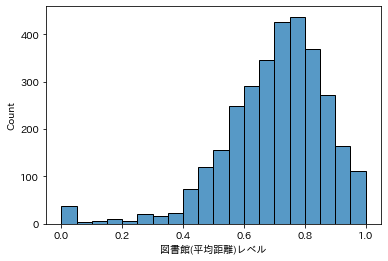

In [21]:
df_pop_master['図書館(平均距離)レベル'] = normalize_score(df_pop_master['図書館(平均距離)'], False)
sns.histplot(df_pop_master['図書館(平均距離)レベル'], bins=20)
plt.show()

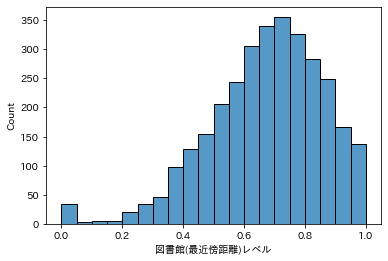

In [22]:
df_pop_master['図書館(最近傍距離)レベル'] = normalize_score(df_pop_master['図書館(最近傍距離)'], False)
sns.histplot(df_pop_master['図書館(最近傍距離)レベル'], bins=20)
plt.show()

In [23]:
score_list = [
    df_pop_master['図書館(最近傍距離)レベル'] * 1.0,
    df_pop_master['図書館(平均距離)レベル'] * 0.7,
    df_pop_master['図書館(数)レベル'] * 0.5,
]
score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

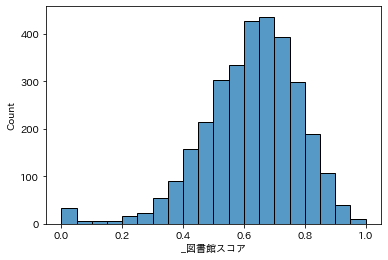

In [24]:
sns.histplot(df_pop_master[score_sub_name], bins=20)
plt.show()

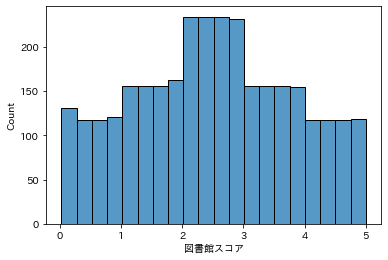

In [25]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [26]:
feature_list = ['図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)']

In [27]:
df_pop_master[
    ['地域ID', '市区町村名', '町丁目'] + feature_list + [score_sub_name, score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

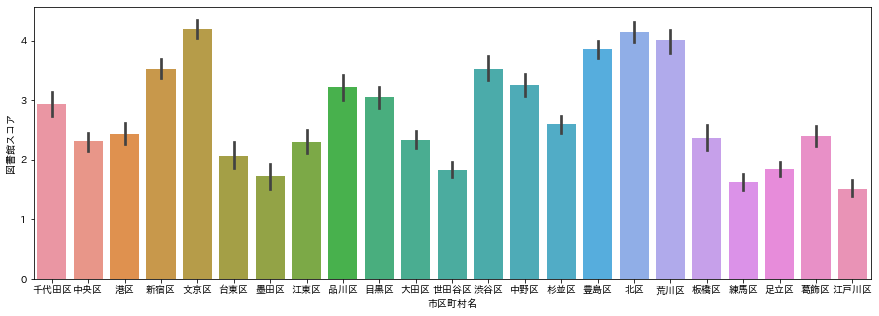

In [28]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [29]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + [score_name, score_sub_name] + feature_list
].reset_index(drop=True)
print(df_level.shape)

(906, 8)


In [30]:
df_level.head(20)

,市区町村名,町名,町丁目,図書館スコア,_図書館スコア,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,北区,上中里,上中里１丁目,5.000000,1.000000,0.126370,0.529664,13
1,北区,田端新町,田端新町２丁目,4.997878,0.991300,0.135295,0.581013,13
2,北区,上十条,上十条３丁目,4.995755,0.987929,0.081841,0.572226,12
3,中野区,東中野,東中野１丁目,4.993633,0.966070,0.104376,0.566147,11
4,北区,田端,田端２丁目,4.991510,0.964457,0.127197,0.434601,11
5,荒川区,西日暮里,西日暮里６丁目,4.989388,0.961159,0.140458,0.510588,11
6,文京区,本駒込,本駒込４丁目,4.987265,0.960126,0.144613,0.416272,11
7,板橋区,本町,本町,4.985143,0.952313,0.018252,0.573943,10
8,新宿区,早稲田鶴巻町,早稲田鶴巻町,4.983020,0.952166,0.072919,0.683466,11
9,北区,東十条,東十条３丁目,4.980898,0.951786,0.025586,0.577180,10


In [31]:
df_level.tail(20)

,市区町村名,町名,町丁目,図書館スコア,_図書館スコア,図書館(最近傍距離),図書館(平均距離),図書館(数)
886,墨田区,太平,太平１丁目,0.443595,0.390118,1.050761,1.682418,2
887,練馬区,三原台,三原台２丁目,0.441473,0.389943,1.079937,1.638889,2
888,板橋区,新河岸,新河岸１丁目,0.411758,0.384071,1.125800,1.604871,2
889,練馬区,谷原,谷原６丁目,0.399024,0.382138,1.076836,1.691609,2
890,江戸川区,東篠崎町,東篠崎町,0.386289,0.379896,1.218062,1.598099,3
891,墨田区,東駒形,東駒形３丁目,0.356574,0.373938,1.241179,1.599386,3
892,台東区,三筋,三筋２丁目,0.326860,0.359874,1.342576,1.530821,3
893,台東区,駒形,駒形１丁目,0.314125,0.356104,1.214606,1.641027,2
894,世田谷区,喜多見,喜多見６丁目,0.307758,0.352520,1.263459,1.588373,2
895,世田谷区,玉堤,玉堤２丁目,0.305635,0.352214,0.957175,1.949899,1
